In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
from fractions import Fraction
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML


sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

In [2]:
nh = 16
refRatio = 2
c = 1.
CFL = 0.5
nt = 11
RK = 4
deriv = 'CD'
order = 0
mu = 0.5
sigma = .1
wavenumber = 35
plot = 2
Hans = False

In [3]:
omegaF = BT.Grid(nh * refRatio)
# t, nt = ST.CalcTime(omegaF, CFL, c, nt = nt)
t = np.sqrt(2)
ct = c * t

In [4]:
def Residuals(omegaF, cellNums = [], refRatio = 2, plot = 0, func = WT.MakeWaves, args = [0]):
    
    # Obtain attributes from master refined grid.
    nh_max = omegaF.nh_max
    xFine = omegaF.xCell
    
    # Create other necessary objects from master refined grid information.
    wavesF = WT.MakeWaves(omegaF)
    strings = PT.FixStrings(omegaF, np.eye(nh_max), False)
    
    ks = np.linspace(0.5, nh_max / 2, num = nh_max)
    nh_min = int(nh_max / refRatio)

    # Get save name info.
    numPoints, font, X, savePath = PT.UsefulPlotVals()
    saveName = savePath + 'FirstModes' + str(nh_min) + '.png'
    
    # Determine iterations over grid proportions and create vector for storing maximum residual norms.
    if (cellNums == []):
        iters = nh_min
    else:
        iters = 1
    residNormMax = np.zeros(iters, float)
    iterAxis = (np.arange(iters) + 1) / nh_min    
    # Iterate over grid refinement proportions.
    for i in range(iters):
        print('i = ', i)
        
        # Instantiate grid with appropriate grid proportions.
        omegaAMR = BT.Grid(nh_min)
#         omegaFAMR = BT.Grid(nh_max)
        if (cellNums == []):
            finehalf = list(np.arange(i + 1))
#             finehalfF = list(np.arange(refRatio * (i + 1)))
        else:
            # Modify this for FAMR!
            finehalf = cellNums
        omegaAMR.AddPatch(refRatio, finehalf)
#         omegaFAMR.AddPatch(refRatio, finehalfF)
        
        degFreed = omegaAMR.degFreed
        xCell = omegaAMR.xCell
        hs = omegaAMR.h
        cells = omegaAMR.cells[-1]

        wavesAMR = WT.MakeWaves(omegaAMR)
#         wavesFAMR = WT.MakeWaves(omegaFAMR)

        nullspace = OT.FindNullspace(omegaAMR, wavesAMR, Hans = Hans)
#         nullspaceF = OT.FindNullspace(omegaFAMR, wavesFAMR, Hans = Hans)
        
        restrictOp = GTT.CoarsenOp(omegaAMR)
#         restrictOpF = GTT.CoarsenOp(omegaFAMR)
        
        # Create the propagated or non-propagated waves in space-space on the fine grid.
        exactF = func(omegaF, *args)
        
        # Find exact Fourier coefficients on fine grid.
        FCoefsExact = FFTT.FourierCoefs(wavesF, exactF)
        
        # Find exact space-space representation on AMR grid.
        exactAMR = restrictOp @ wavesF @ FCoefsExact
        
        # Find test Fourier coefficients on AMR grid.
        if (args == [0]):
            FCoefsTest = FFTT.FourierCoefs(wavesAMR @ nullspace, exactAMR, False)
        else:
            FCoefsTest = FFTT.PropRestrictWaves(omegaAMR, wavesF, ct)
        
        # Find test space-space representation on AMR grid.
        testAMR = wavesAMR @ nullspace @ FCoefsTest
        
        resid = abs(exactAMR - testAMR)
        residNorm = TT.VectorNorm(resid, normType = 'max')
        
        # Iterate through plotting residuals for 
        if ((plot > 2) and (func is WT.MakeWaves)):# and (residNorm[j] > 1e-11)):
        

            for j in range(nh_max):
                if (j % 1 == 0):
                    fig1, ax1 = plt.subplots(figsize = [12, 4])
                    ax1.plot(xFine, exactF[:, j], lw = 1, color = PT.ColorDefault(0), label = 'Exact Fine Solution')
                    ax1.plot(xCell, exactAMR[:, j], lw = 1, color = PT.ColorDefault(1), linestyle = '--', label = 'Exact AMR Solution')
                    ax1.plot(xCell, testAMR[:, j], lw = 1, color = PT.ColorDefault(2), linestyle = ':', label = 'NUDFT AMR Solution')
                    plt.title('AMR and Fine Representations of ' + strings[j])
                    plt.xlabel('$x$')
                    plt.ylabel('Waveform')
                    plt.legend()

                    fig2, ax2 = plt.subplots(figsize = [12, 4])
                    ax2.plot(xCell, resid[:, j], lw = 1)
                    plt.title('Residuals for ' + strings[j])
                    plt.xlabel('$x$')
                    plt.ylabel('Residuals')
                    plt.show()
                    print('\n\n\n\n')    

#         PT.PlotWaves(omegaAMR, waves = wavesAMR, nullspace = nullspace)
#                     if (residNorm[j] > 1e-11):
#                         saveName1 = savePath + 'WaveReps' + str(j) + '.png'
#                         saveName2 = savePath + 'Residuals' + str(j) + '.png'
        #                 fig1.savefig(saveName1, bbox_inches = 'tight', dpi = 300, transparent = True)
        #                 fig2.savefig(saveName2, bbox_inches = 'tight', dpi = 300, transparent = True)

        residNormMax[i] = TT.VectorNorm(residNorm, normType = 'max')
        if (plot > 1):
            numer = str(Fraction(i + 1, nh_min).numerator)
            denom = str(Fraction(i + 1, nh_min).denominator)
            fig, ax = plt.subplots(figsize = [12, 4])
            plt.plot(ks, residNorm)
            ax.grid(True, axis = 'both', zorder = 0)
            plt.yscale('log')
            plt.title(r'Residual Max Norm by Wavenumber for $\frac{' + numer + '}{' + denom + '}$ Grid Refined')
            plt.ylabel('Residual Norm')
            plt.xlabel('Wavenumber')
            plt.show()
        print('end loop i = ', i)
        print('')
        print('')
    if ((plot > 0) and (cellNums == [])):
        fig, ax = plt.subplots(figsize = [12, 4])
        plt.plot(iterAxis, residNormMax, color = PT.ColorDefault(0), lw = 1)
        plt.scatter(iterAxis, residNormMax, color = PT.ColorDefault(0), s = 8)
        # plt.plot(ks, 1e-13 * np.ones(nh_max, float))
        ax.grid(True, axis = 'both', zorder = 0)
        plt.yscale('log')
        plt.title(r'Residual Max Norm by Proportion of Grid Refined')
        plt.ylabel('Residual Norm')
        plt.xlabel('Grid Proportion')
        fig.savefig(saveName, bbox_inches = 'tight', dpi = 300, transparent = True)
        plt.show()
    return

i =  0


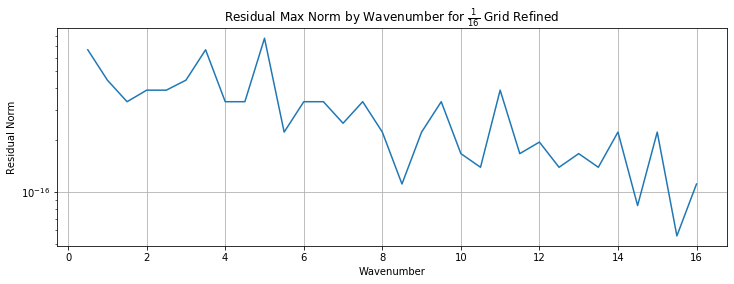

end loop i =  0


i =  1


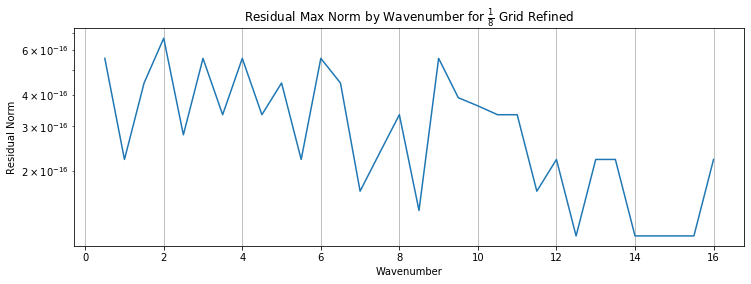

end loop i =  1


i =  2


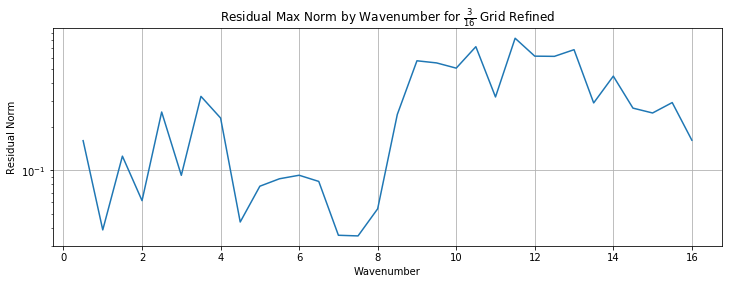

end loop i =  2


i =  3


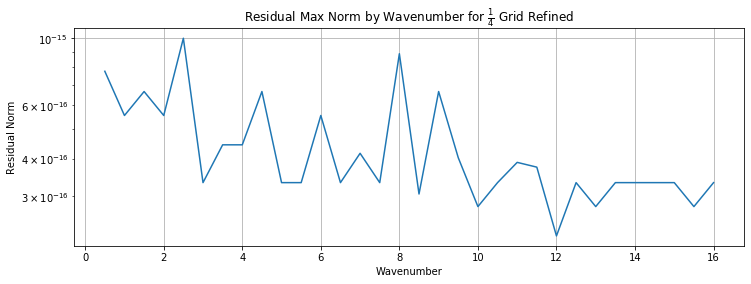

end loop i =  3


i =  4


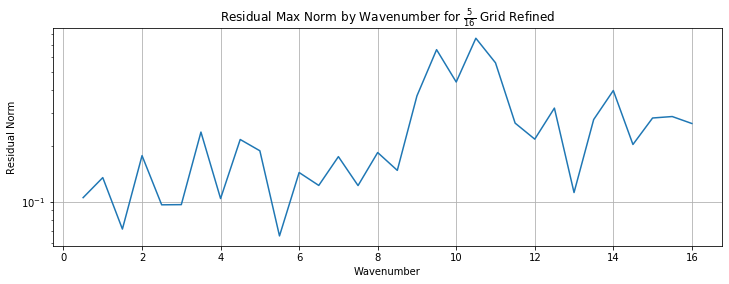

end loop i =  4


i =  5


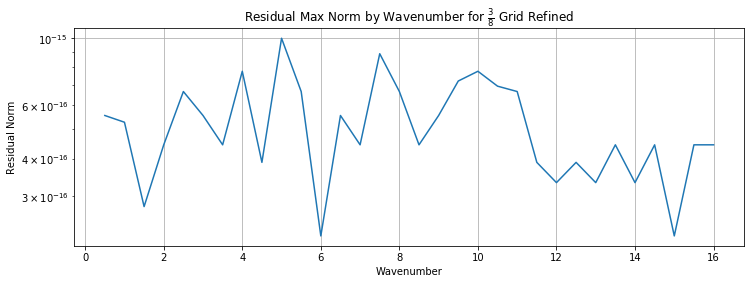

end loop i =  5


i =  6


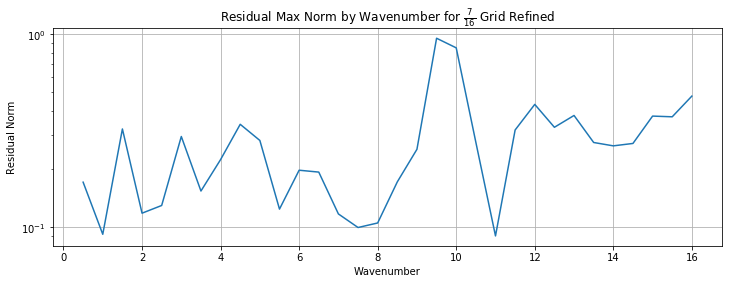

end loop i =  6


i =  7


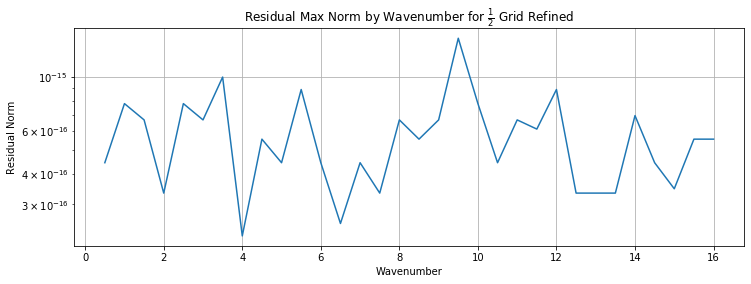

end loop i =  7


i =  8


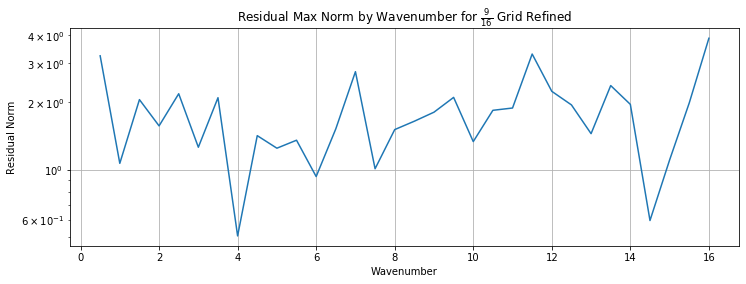

end loop i =  8


i =  9


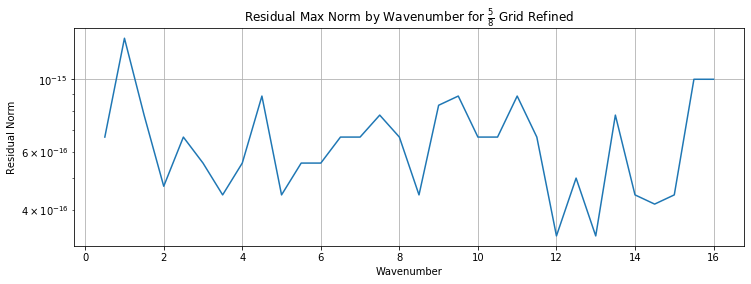

end loop i =  9


i =  10


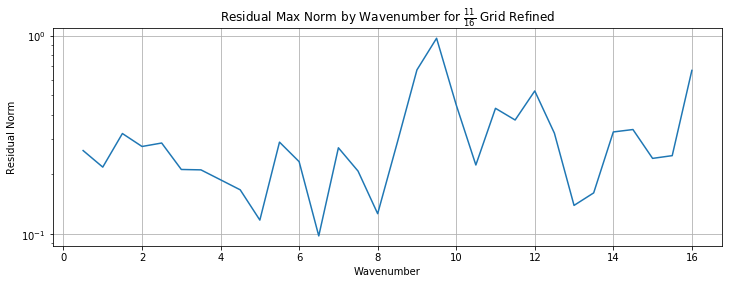

end loop i =  10


i =  11


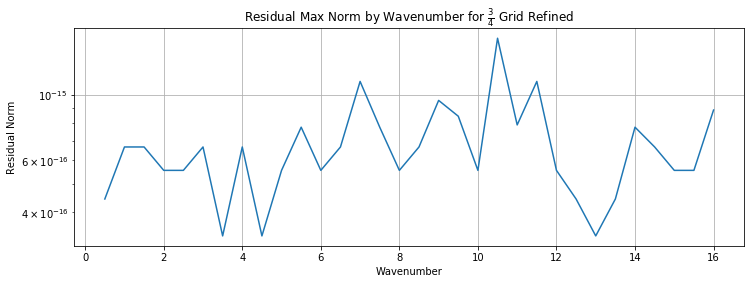

end loop i =  11


i =  12


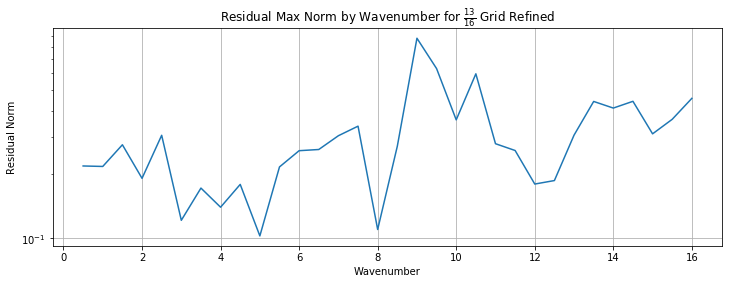

end loop i =  12


i =  13


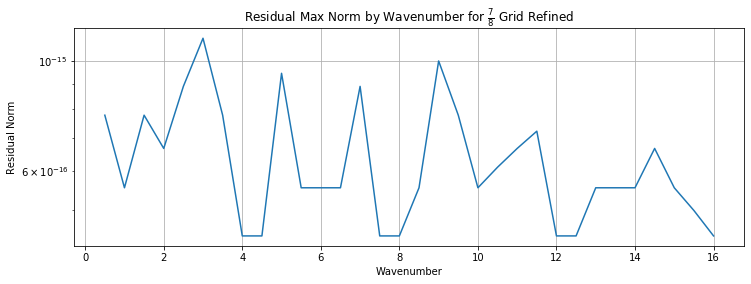

end loop i =  13


i =  14


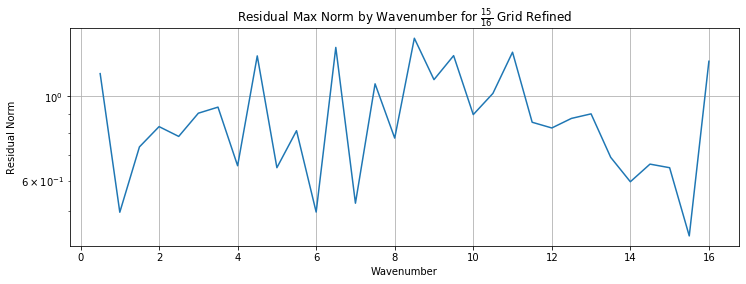

end loop i =  14


i =  15


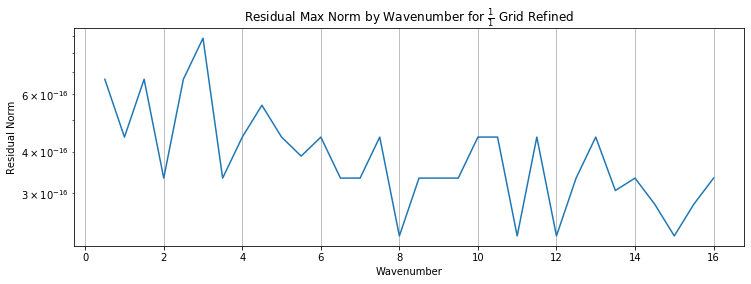

end loop i =  15




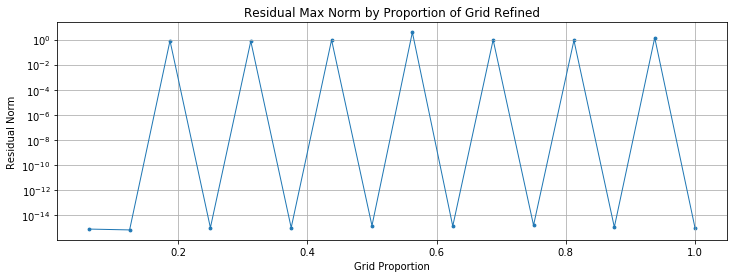

In [5]:
Residuals(omegaF, plot = plot)